<a href="https://colab.research.google.com/github/markusloecher/DataScience2021/blob/main/TWSM/Class5_solution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Libraries

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
TWSM_path = "/content/drive/MyDrive/teaching/TWSM/"

#from TWSM import *
from tensorflow import keras
from tensorflow.keras import layers
import spacy
## Import packages
import pickle
import pandas as pd
from gensim.models import Word2Vec



Mounted at /content/drive


## Data

**IMD Movie Reviews**

#### Tasks

1. Train a word2vec model of dimension $100$ on the IMD data. (considering words appearing in more than 50 documents) Save the model if you like.

2. Compute the embedding for each review (average word2vec)

3. Fit a keras classifier to the embedded reviews. (2 hidden layers of size 40 each) Report/Monitor the accuracy on the test data.

4. Load the bing sentiment dictionary. Compute two separate embeddings for the negative and positive sentiments.

5. Compute the similarity between these two vectors and a few selected reviews. Does it agree with their label?


-------------------------------------------
## Solution

Decoding reviews back to text

In [ ]:
ReloadIMDB=False

if ReloadIMDB:
  from tensorflow.keras.datasets import imdb
  (train_data, train_labels), (test_data, test_labels) = imdb.load_data(
    num_words=10000)

  word_index = imdb.get_word_index()
  reverse_word_index = dict(
    [(value, key) for (key, value) in word_index.items()])
  
  N=len(train_data)
  decoded_reviews = ["" for x in range(N)]

  for j in range(N):
    decoded_reviews[j] = " ".join(
      [reverse_word_index.get(i - 3, "?") for i in train_data[j]])  
    
    N=len(test_data)
  decoded_reviews_test = ["" for x in range(N)]

  for j in range(N):
    decoded_reviews_test[j] = " ".join(
      [reverse_word_index.get(i - 3, "?") for i in test_data[j]])
    
  pickle.dump(decoded_reviews_test, open(TWSM_path + "data/IMDB/decoded_reviews_test.pkl", "wb"))
  pickle.dump(decoded_reviews, open(TWSM_path + "data/IMDB/decoded_reviews_train.pkl", "wb"))
  pickle.dump(train_labels, open(TWSM_path + "data/IMDB/train_labels.pkl", "wb"))
  pickle.dump(test_labels, open(TWSM_path + "data/IMDB/test_labels.pkl", "wb"))
else:
  decoded_reviews_test = pickle.load(open(TWSM_path + "data/IMDB/decoded_reviews_test.pkl", "rb"))
  decoded_reviews = pickle.load(open(TWSM_path + "data/IMDB/decoded_reviews_train.pkl", "rb"))
  train_labels = pickle.load(open(TWSM_path + "data/IMDB/train_labels.pkl", "rb"))
  test_labels = pickle.load(open(TWSM_path + "data/IMDB/test_labels.pkl", "rb"))

Train the Embedding model

In [ ]:
# Prepare the dataset for the word2vec model
corpus_imdb=[doc.split() for doc in decoded_reviews]

# Train the model for embeddings of size 100 considering words appearing in more than 50 documents, default window=5
model = Word2Vec(corpus_imdb, size=100, min_count=50)


In [ ]:
model.wv.most_similar(positive=['actress', 'actor'], topn=5)

[('performer', 0.7539661526679993),
 ('role', 0.7292031049728394),
 ('singer', 0.6907426714897156),
 ('performance', 0.6768022775650024),
 ('artist', 0.6377604007720947)]

In [ ]:
model.save(TWSM_path+'models/IMDB_word2vec.model')

Embed training reviews


In [ ]:
# Document representation for the text
corpus_w2v=[[model.wv[word] for word in doc if word in model.wv.vocab.keys()] for doc in corpus_imdb]
positive=[i for i in range(len(corpus_imdb)) if len(corpus_w2v[i])>0]

In [ ]:
corpus_w2v2=[corpus_w2v[i] for i in positive]

# Document average representation
corpus_w2v_avg_clean=[sum(words)/len(words) for words in corpus_w2v2]

# Corpus as data frame that can be used in downstream tasks such as classification
corpus_w2v_avg_df=pd.DataFrame(corpus_w2v_avg_clean)
corpus_w2v_avg_df.head()


,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,0.124081,0.368535,-0.149254,-0.189179,0.221026,0.325926,0.480088,-0.572645,-0.602477,0.454659,...,0.239557,0.706650,0.022246,-0.023969,0.367418,0.212499,0.524909,-0.347697,-0.229221,-0.152529
1,-0.131859,0.297526,0.086309,-0.072801,0.195620,0.209143,0.365044,-0.644183,-0.258637,0.028983,...,0.080747,0.352514,-0.184508,-0.114032,0.026449,0.161618,0.091426,-0.116344,-0.121862,-0.148958
2,-0.242112,0.606146,-0.126749,-0.081348,0.176170,0.476083,0.459211,-0.621167,-0.719172,0.644027,...,0.273534,0.887905,-0.158114,-0.167328,0.272952,0.094429,0.387983,-0.439316,-0.118263,-0.066035
3,-0.264141,0.211701,0.006838,0.069322,0.245065,0.275938,0.379437,-0.220990,-0.459105,0.242493,...,0.064097,0.410491,0.054655,-0.092702,-0.109929,0.031859,0.306187,-0.043223,-0.264528,-0.074083
4,-0.189060,0.771490,-0.216529,-0.292080,-0.066199,0.474550,0.587958,-0.505710,-0.693489,0.560967,...,0.505673,1.004113,-0.197803,0.054256,0.380934,0.259278,0.440375,-0.430701,-0.041191,-0.236806


In [ ]:
model.wv.similar_by_vector(corpus_w2v_avg_clean[0], topn=5)

[('it', 0.6968493461608887),
 ('really', 0.6696332693099976),
 ('just', 0.6292071342468262),
 ('disappointed', 0.6222279071807861),
 ('actually', 0.6026661396026611)]

Embed test reviews

In [ ]:
corpus_imdb_test =[doc.split() for doc in decoded_reviews_test]

In [ ]:
# Document representation for the text
corpus_w2v_test=[[model.wv[word] for word in doc if word in model.wv.vocab.keys()] for doc in corpus_imdb_test]
positive_test=[i for i in range(len(corpus_imdb_test)) if len(corpus_w2v_test[i])>0]

In [ ]:
corpus_w2v2_test=[corpus_w2v_test[i] for i in positive_test]

# Document average representation
corpus_w2v_avg_clean_test=[sum(words)/len(words) for words in corpus_w2v2_test]

# Corpus as data frame that can be used in downstream tasks such as classification
corpus_w2v_avg_df_test=pd.DataFrame(corpus_w2v_avg_clean_test)
corpus_w2v_avg_df_test.head()


,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,-0.104860,0.340449,-0.053031,0.006887,0.296573,0.175297,0.627474,-0.619944,-0.696076,0.355007,...,0.345004,0.674266,-0.136591,-0.134364,0.086184,0.482008,0.617528,-0.116125,0.118367,-0.298689
1,-0.136378,0.115994,-0.240296,0.006467,0.157939,0.033500,0.198721,-0.540978,-0.231891,0.273509,...,-0.009848,0.285836,-0.041590,0.021366,0.049833,0.080068,0.372657,-0.053558,-0.369463,-0.144664
2,-0.187094,0.110841,-0.054470,0.056479,0.190619,0.266484,0.271450,-0.214446,-0.379376,0.199574,...,-0.057212,0.393354,-0.017578,-0.103430,-0.098210,-0.047082,0.202616,-0.034333,-0.384147,0.001046
3,-0.189191,0.477493,-0.126869,-0.079079,0.097771,0.346672,0.506993,-0.477076,-0.787435,0.425800,...,0.244254,0.872361,0.030797,0.070223,0.386045,0.319238,0.392960,-0.376618,0.002613,-0.203659
4,-0.044688,0.645072,-0.109225,-0.072272,0.067841,0.504365,0.397634,-0.357952,-0.532977,0.463198,...,0.382792,0.608299,-0.124581,0.188016,0.635152,0.510019,0.095109,-0.217129,0.276952,-0.472512


NN classifier

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers

NN_imdb = keras.Sequential([
    layers.Dense(40, activation="relu"),
    layers.Dense(40, activation="relu"),
    layers.Dense(1, activation="sigmoid")
])

NN_imdb.compile(optimizer="rmsprop",
              loss="binary_crossentropy",
              metrics=["accuracy"])

**Training your model**

In [ ]:
history = NN_imdb.fit(corpus_w2v_avg_df,
                    train_labels,
                    epochs=10,
                    batch_size=512,
                    validation_data=(corpus_w2v_avg_df_test, test_labels))

Epoch 1/10
49/49 [==============================] - 1s 9ms/step - loss: 0.5866 - accuracy: 0.7096 - val_loss: 0.5027 - val_accuracy: 0.7817
Epoch 2/10
49/49 [==============================] - 0s 5ms/step - loss: 0.4632 - accuracy: 0.7928 - val_loss: 0.4330 - val_accuracy: 0.8087
Epoch 3/10
49/49 [==============================] - 0s 4ms/step - loss: 0.4171 - accuracy: 0.8134 - val_loss: 0.4236 - val_accuracy: 0.8057
Epoch 4/10
49/49 [==============================] - 0s 4ms/step - loss: 0.4015 - accuracy: 0.8222 - val_loss: 0.4204 - val_accuracy: 0.8036
Epoch 5/10
49/49 [==============================] - 0s 4ms/step - loss: 0.3948 - accuracy: 0.8256 - val_loss: 0.3964 - val_accuracy: 0.8196
Epoch 6/10
49/49 [==============================] - 0s 5ms/step - loss: 0.3881 - accuracy: 0.8286 - val_loss: 0.3828 - val_accuracy: 0.8313
Epoch 7/10
49/49 [==============================] - 0s 4ms/step - loss: 0.3855 - accuracy: 0.8300 - val_loss: 0.3889 - val_accuracy: 0.8242
Epoch 8/10
49/49 [==

In [ ]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

**Plotting the training and validation loss**

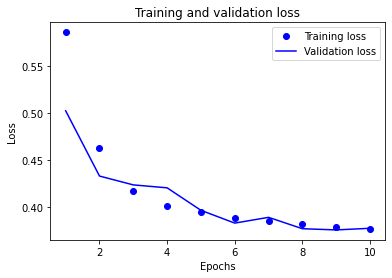

In [ ]:
import matplotlib.pyplot as plt
history_dict = history.history
loss_values = history_dict["loss"]
val_loss_values = history_dict["val_loss"]
epochs = range(1, len(loss_values) + 1)
plt.plot(epochs, loss_values, "bo", label="Training loss")
plt.plot(epochs, val_loss_values, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

Sentiment dictionary

In [ ]:
bing = pd.read_csv(TWSM_path+"data/bing.csv")

bing

,Unnamed: 0,word,sentiment
0,1,2-faces,negative
1,2,abnormal,negative
2,3,abolish,negative
3,4,abominable,negative
4,5,abominably,negative
...,...,...,...
6781,6782,zealously,negative
6782,6783,zenith,positive
6783,6784,zest,positive
6784,6785,zippy,positive


Load the bing sentiment dictionary. Compute two separate embeddings for the negative and positive sentiments.

Compute the similarity between these two vectors and a few selected reviews. Does it agree with their label?

In [ ]:
positiveWords = bing[bing["sentiment"]=="positive"]["word"]
positiveWords

10          abound
11         abounds
24       abundance
25        abundant
33      accessable
           ...    
6774      youthful
6778          zeal
6782        zenith
6783          zest
6784         zippy
Name: word, Length: 2005, dtype: object

In [ ]:
negativeWords = bing[bing["sentiment"]=="negative"]["word"]
negativeWords

0          2-faces
1         abnormal
2          abolish
3       abominable
4       abominably
           ...    
6777          zaps
6779        zealot
6780       zealous
6781     zealously
6785        zombie
Name: word, Length: 4781, dtype: object

In [ ]:
# Document representation for the positive
corpus_w2v=[[model.wv[word] for word in doc if word in model.wv.vocab.keys()] for doc in positiveWords]
positive=[i for i in range(len(positiveWords)) if len(corpus_w2v[i])>0]

corpus_w2v2=[corpus_w2v[i] for i in positive]
#data_lemma2=[data_lemma[i] for i in positive]

# Document average representation
corpus_w2v_avg_clean=[sum(words)/len(words) for words in corpus_w2v2]


In [ ]:
# cosine similarity to other documents
from scipy.spatial.distance import cosine

result=[(1 - cosine(corpus_w2v_avg_clean[0],corpus_w2v_avg_clean[i])) for i in range(1,len(corpus_w2v_avg_clean))]
#most_similar=data_lemma2[result.index(max(result))+1]
#print(data_lemma2[0])
#print('')
#print(most_similar)
result.index(max(result))

0